In [1]:
import os
import sys
import argparse
import copy
import pickle

import cv2
import xml.etree.ElementTree as et

import numpy as np

from openvino.inference_engine import IECore

import matplotlib.pyplot as plt

In [2]:
MODEL_PATH = 'model/FP16/'
DATA_PATH = 'data/'

# Helper functions

In [153]:
def splitFileName(file):
    dirname, filename = os.path.split(file)
    basename, extname = os.path.splitext(filename)
    return dirname, basename, extname

def readXML(model):
    dname, bname, ename = splitFileName(model)
    tree = et.parse(os.path.join(dname, bname+'.xml'))
    return tree

def readBIN(model):
    dname, bname, ename = splitFileName(model)
    with open(os.path.join(dname, bname+'.bin'), 'rb') as f:
        weight = f.read()
    return weight


def findNodeFromXML(xmltree, nodeid):
    root = xmltree.getroot()
    layers = root.find('layers')
    for layer in layers.findall('layer'):
        if int(layer.attrib['id']) == nodeid:
            return layer
    return None


def modifyXMLForFeatureVectorProbing(xmltree, nodeid):
    xmlcopy = copy.deepcopy(xmltree)
    layer = findNodeFromXML(xmlcopy, nodeid)

    # obtain output port information of the target node (port # and dims)
    outport      = layer.find('output').find('port')
    outport_id   = int(outport.attrib['id'])
    outport_prec = outport.attrib['precision']
    outport_dims = outport.findall('dim')
    outport_dims_string = ""
    for dim in outport_dims:
        outport_dims_string += et.tostring(dim).decode('utf-8')

    # generate XML strings
    dummyLayer = """
        <layer id="9999" name="featuremap_checker_dummy_node" type="Result" version="opset1">
            <input>
                <port id="0">
                {}
                </port>
            </input>
        </layer>
    """.format(outport_dims_string)
    dummyEdge = '        <edge from-layer="{}" from-port="{}" to-layer="9999" to-port="0"/>'.format(nodeid, outport_id)

    # modify XML to make a dummy branch path for feature map extraction
    xmlcopy.find('layers').append(et.fromstring(dummyLayer))
    xmlcopy.find('edges').append(et.fromstring(dummyEdge))

    # return the modified XML and the name of the target node (specified by 'nodeid')
    return xmlcopy, layer.attrib['name']


def prepareInputs(net_inputs, fn):
    input_data = {}

    input_blob_names  = list(net_inputs.keys())

    input0Name = input_blob_names[0]
    input0Info = net_inputs[input0Name]
    N,C,H,W = input0Info.tensor_desc.dims
    img = cv2.imread(fn)    # default = image.jpg
    img = cv2.resize(img, (W, H))
    img = img.transpose((2, 0, 1))
    img = img.reshape((1, C, H, W))
    input_data[input0Name] = img

    print(input_data)
    return input_data


def product(lis):
        if len(lis) == 0:
            return 0
        else:
            res = 1
            for x in lis:
                res *= x
            return res

def calc_rf(f, stride):
    rf = []
    for i in range(len(f)):
        if i == 0:
            rf.append(3)
        else:
            rf.append(rf[i-1] + (f[i]-1) * product(stride[:i]))
    return rf

def calc_l_star(template, rf):
    k = 3
    l = np.sum(rf <= min(list(template.shape[-2:]))) - 1
    l_star = max(l - k, 1)
    return l_star

# Read Model IR File

In [162]:
originalXML = readXML(MODEL_PATH + 'custom_vgg16.xml')
weight = readBIN(MODEL_PATH + 'custom_vgg16.xml')
feature_vectors = {}
ie = IECore()
root = originalXML.getroot()
layers = root.find('layers')

# Parse model IR

In [163]:
print('node# : nodeName')
f = []
strides = []
names = []
feature_vectors = {}

ie = IECore()
root = originalXML.getroot()
layers = root.find('layers')
for layer in layers.findall('layer'):
    nodeName = layer.attrib['name']
    nodeid = int(layer.attrib['id'])
    nodetype = layer.attrib['type']
    
    if nodetype in ['Convolution']:
        const = layers[nodeid-1]
        kernel_size = const.find('data').attrib['shape'][-1]
        stride = layer.find('data').attrib['strides'][-1]
        f.append(int(kernel_size))
        strides.append(int(stride))
        names.append(nodeName)
    
    if nodetype in ['MaxPool']:
        kernel_size = layer.find('data').attrib['kernel'][-1]
        stride = layer.find('data').attrib['strides'][-1]
        f.append(int(kernel_size))
        strides.append(int(stride))
        names.append(nodeName)
    
    if nodetype in ['Const']: # , 'ShapeOf', 'Convert', 'StridedSlice', 'PriorBox']:
        #print(nodetype)
        continue
        
print(f)
print(strides)
print(names)


rf = np.array(calc_rf(f, strides))
print(rf)

node# : nodeName
[3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2]
[1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2]
['Conv_0/WithoutBiases', 'Conv_2/WithoutBiases', 'MaxPool_4', 'Conv_5/WithoutBiases', 'Conv_7/WithoutBiases', 'MaxPool_9', 'Conv_10/WithoutBiases', 'Conv_12/WithoutBiases', 'Conv_14/WithoutBiases', 'MaxPool_16', 'Conv_17/WithoutBiases', 'Conv_19/WithoutBiases', 'Conv_21/WithoutBiases', 'MaxPool_23', 'Conv_24/WithoutBiases', 'Conv_26/WithoutBiases', 'Conv_28/WithoutBiases', '57']
[  3   5   6  10  14  16  24  32  40  44  60  76  92 100 132 164 196 212]


# Hook function

In [202]:
def hook(target_layer, image):
    for layer in layers.findall('layer'):
        nodeid = int(layer.attrib['id'])
        nodetype = layer.attrib['type']
        nodeName = layer.attrib['name']
        if nodetype in ['Const']: # , 'ShapeOf', 'Convert', 'StridedSlice', 'PriorBox']:
            continue
        if nodeName != names[target_layer]:
            continue
        if not layer.find('output') is None:

            outputport = layer.find('output').find('port')
            proc = outputport.attrib['precision']
            dims = []
            for dim in outputport.findall('dim'):                       # extract shape information
                dims.append(dim.text)

            modifiedXML, targetNodeName = modifyXMLForFeatureVectorProbing(originalXML, nodeid)
            XMLstr = et.tostring(modifiedXML.getroot())
            print('{} : {}'.format(nodeid, targetNodeName))

            net = ie.read_network(XMLstr, weight, init_from_buffer=True)
            
            # Reshape
            input_blob = next(iter(net.inputs))
            out_blob = next(iter(net.outputs))
            n, c, h, w = net.input_info[input_blob].input_data.shape
            c_img, h_img, w_img  = image.shape
            print(h_img, w_img)
            net.reshape({input_blob: (n, c, h_img, w_img)})
            
            try:
                exenet = ie.load_network(net, 'CPU')
            except RuntimeError:
                #et.dump(modifiedXML)
                print('*** RuntimeError: load_network() -- Skip node \'{}\' - \'{}\''.format(targetNodeName, nodetype))
                continue
            
            
            #inputs = prepareInputs(net.input_info, 'dog.jpg')
            res = exenet.infer(inputs={input_blob: image})[nodeName]
            #print(nodeName, res)
            del exenet
            del net
            
            return res
        


# Input

In [ ]:
sample_image_path = 'sample1.jpg'
template_image_path = 'template1.png'

In [308]:
sample_raw = cv2.imread(DATA_PATH + sample_image_path)
sample_height, sample_width, sample_channels = sample_raw.shape
print(sample_height, sample_width, sample_channels)
sample = sample_raw.transpose((2, 0, 1))

371 668 3


In [309]:
template_raw = cv2.imread(DATA_PATH + template_image_path)
template_height, template_width, template_channels = template_raw.shape
print(template_height, template_width, template_channels)
template = template_raw.transpose((2, 0, 1))

183 130 3


In [328]:
l_star = calc_l_star(template, rf)
print('Target Layer(L*):',l_star)

Target Layer(L*): 10


# Get Feature map

In [311]:
F = hook(l_star, template).astype(np.float32)
print(F.shape)

Conv_17/WithoutBiases
40 : Conv_17/WithoutBiases
183 130
(1, 512, 22, 16)


/tmp/ipykernel_1337347/1243409711.py:29: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  input_blob = next(iter(net.inputs))


In [312]:
M = hook(l_star, sample).astype(np.float32)
print(M.shape)

Conv_17/WithoutBiases
40 : Conv_17/WithoutBiases
371 668
(1, 512, 46, 83)


/tmp/ipykernel_1337347/1243409711.py:29: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  input_blob = next(iter(net.inputs))


# Calculate NCC

In [279]:
def calc_NCC(F, M):
    c, h_f, w_f = F.shape[-3:]
    tmp = np.zeros((c, M.shape[-2] - h_f, M.shape[-1] - w_f, h_f, w_f))
    for i in range(M.shape[-2] - h_f):
        for j in range(M.shape[-1] - w_f):
            M_tilde = M[:, :, i:i+h_f, j:j+w_f][:, None, None, :, :]
            tmp[:, i, j, :, :] = M_tilde / np.linalg.norm(M_tilde)
    NCC = np.sum(tmp*F.reshape(F.shape[-3], 1, 1, F.shape[-2], F.shape[-1]), axis=(0, 3, 4))
    return NCC

In [313]:
NCC = calc_NCC(F, M)

In [314]:
threshold = 0.95 * np.max(NCC)
max_indices = np.array(np.where(NCC > threshold)).T
print("detected boxes: {}".format(len(max_indices)))

detected boxes: 1


# Re-position of boxes

In [315]:
template_feature_map = F
image_feature_map = M

In [317]:
sample_size = sample.shape
template_size = template.shape

In [318]:
boxes = []
centers = []
scores = []
for max_index in max_indices:
    i_star, j_star = max_index
    NCC_part = NCC[i_star-1:i_star+2, j_star-2:j_star+2]
    
    
    x_center = (j_star + template_feature_map.shape
                [-1]/2) * sample_size[-1] // image_feature_map.shape[-1]
    y_center = (i_star + template_feature_map.shape
                [-2]/2) * sample_size[-2] // image_feature_map.shape[-2]
    
    x1_0 = x_center - template_size[-1]/2
    x2_0 = x_center + template_size[-1]/2
    y1_0 = y_center - template_size[-2]/2
    y2_0 = y_center + template_size[-2]/2

    stride_product = float(product(stride[:l_star]))
    
    x1 = np.sum(
        NCC_part * (x1_0 + np.array([-2, -1, 0, 1]) * stride_product)[None, :]) / np.sum(NCC_part)
    x2 = np.sum(
        NCC_part * (x2_0 + np.array([-2, -1, 0, 1]) * stride_product)[None, :]) / np.sum(NCC_part)
    y1 = np.sum(
        NCC_part * (y1_0 + np.array([-1, 0, 1]) * stride_product)[:, None]) / np.sum(NCC_part)
    y2 = np.sum(
        NCC_part * (y2_0 + np.array([-1, 0, 1]) * stride_product)[:, None]) / np.sum(NCC_part)

    x1 = int(round(x1))
    x2 = int(round(x2))
    y1 = int(round(y1))
    y2 = int(round(y2))
    x_center = int(round(x_center))
    y_center = int(round(y_center))

    boxes.append([(x1, y1), (x2, y2)])
    centers.append((x_center, y_center))
    scores.append(np.sum(NCC_part))

# NMS find best score

In [263]:
def nms(dets, scores, thresh):
    x1 = dets[:, 0, 0]
    y1 = dets[:, 0, 1]
    x2 = dets[:, 1, 0]
    y2 = dets[:, 1, 1]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

In [319]:
nms_res = nms(np.array(boxes), np.array(scores), thresh=0.5)

In [320]:
res_img = sample_raw.copy()
res_img = cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB)

In [322]:
for i in nms_res:
    res_img = cv2.rectangle(res_img, boxes[i][0], boxes[i][1], (255, 0, 0), 3)
    res_img = cv2.circle(res_img, centers[i], int(
        (boxes[i][1][0] - boxes[i][0][0])*0.2), (0, 0, 255), 2)

# Sample

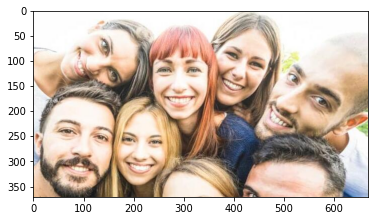

In [324]:
plt.imshow(cv2.cvtColor(sample_raw, cv2.COLOR_BGR2RGB))

# Template

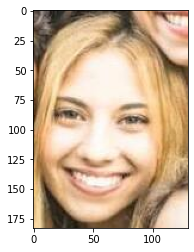

In [325]:
plt.imshow(cv2.cvtColor(template_raw, cv2.COLOR_BGR2RGB))

# Template-Matching Result

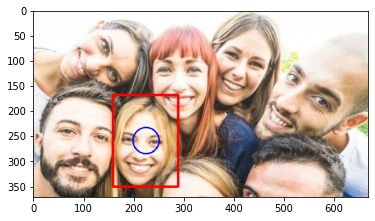

In [326]:
plt.imshow(res_img)